# 1. load datasets

In [3]:
from sklearn.datasets import fetch_mldata
import numpy as np
mnist = fetch_mldata('MNIST original')

In [4]:
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [5]:
X, y = mnist["data"], mnist["target"]

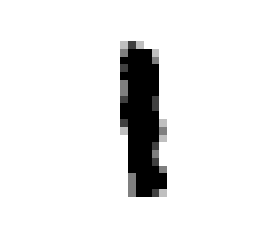

1.0


In [6]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
some_digit = X[10050]
def plot_digit(some_digit):
    some_digit_image = some_digit.reshape(28, 28)
    plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest")
    plt.axis("off")
    plt.show()
plot_digit(some_digit)
print(y[10050])

In [7]:
# split training and test set
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [8]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# 2. Train a binary classifer

In [9]:
from sklearn.linear_model import SGDClassifier
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [10]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

/Users/lgrcyanny/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [11]:
sgd_clf.predict(X_test)[1000]

False

In [12]:
y_test_5[1000]

False

# 3. Evaluate Model Performance

In [13]:
# 1. accuracy, cross_val_score

In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))  # prints 0.9502, 0.96565 and 0.96495

0
0
0


In [15]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.96485,  0.89565,  0.90565])

In [16]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [17]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.91055,  0.9093 ,  0.9091 ])

In [18]:
# 2. confusion matrix

In [19]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
confusion_matrix(y_train_5, y_train_pred)

array([[50830,  3749],
       [  928,  4493]])

In [21]:
precision_score(y_train_5, y_train_pred)

0.5451346760495025

In [22]:
recall_score(y_train_5, y_train_pred)

0.82881387197933964

In [23]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.65768864817390016

In [24]:
# 3. trade off Precision and recall

In [25]:
some_digit = X_test[1000]
y_scores = sgd_clf.decision_function([some_digit])

In [26]:
y_test_5[1000]

False

In [28]:
from sklearn.metrics import precision_recall_curve
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [29]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores[:, 1])

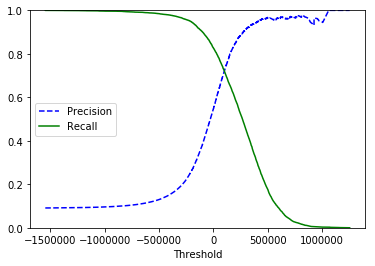

In [30]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0, 1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [31]:
y_train_pred_90 = (y_scores > 70000)[:, 1]
y_train_pred_90.shape

(60000,)

In [32]:
precision_score(y_train_5, y_train_pred_90)

0.66763990267639906

In [33]:
recall_score(y_train_5, y_train_pred_90)

0.75926950747094635

In [34]:
# 4. ROC Curve

In [35]:
from sklearn.metrics import roc_curve

In [36]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores[:, 1])

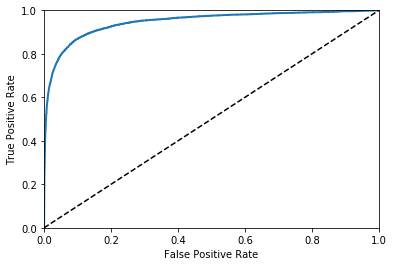

In [37]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
plot_roc_curve(fpr, tpr, label="roc curve")
plt.show()

In [38]:
from sklearn.metrics import roc_auc_score
auc_score = roc_auc_score(y_train_5, y_scores[:, 1])
auc_score

0.94666469446752954

In [39]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [40]:
y_probas_forest.shape

(60000, 2)

In [43]:
y_scores_forest = y_probas_forest[:, 1]

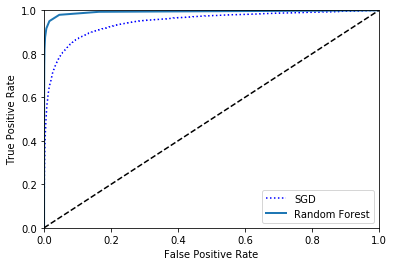

In [44]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")

In [45]:
roc_auc_score(y_train_5, y_scores_forest)

0.99294597445518806

# 4. Multi Class Classification

In [46]:
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [47]:
scores = sgd_clf.predict(X_test)
scores[900]

0.0

In [48]:
np.argmax(sgd_clf.decision_function(X_test)[900])

0

In [49]:
sgd_clf.classes_[6]

6.0

In [50]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))

In [51]:
ovo_clf.fit(X_train, y_train)

OneVsOneClassifier(estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False),
          n_jobs=1)

In [52]:
ovo_clf.predict(X_test)

array([ 0.,  0.,  0., ...,  9.,  9.,  9.])

In [53]:
len(ovo_clf.estimators_)

45

In [54]:
forest_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [55]:
forest_clf.predict_proba([some_digit])

array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [56]:
cross_val_score(sgd_clf, X_train, y_train, cv=4, scoring="accuracy")

array([ 0.84651783,  0.86401813,  0.85778104,  0.85481827])

In [57]:
# improve accuracy with standard scaler

In [58]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([ 0.90996335,  0.91061192,  0.91525537,  0.90770257])

# 5. Error Analysis

In [59]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

In [60]:
conf_metrix = confusion_matrix(y_train, y_train_pred)

In [61]:
conf_metrix.shape

(10, 10)

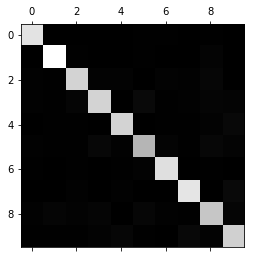

In [62]:
plt.matshow(conf_metrix, cmap=plt.cm.gray)
plt.show()

In [65]:
row_sums = conf_metrix.sum(axis=1, keepdims=True)

In [66]:
norm_conf_metrix = conf_metrix / row_sums

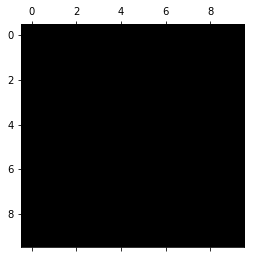

In [67]:
np.fill_diagonal(norm_conf_metrix, 0)
plt.matshow(norm_conf_metrix, cmap=plt.cm.gray)
plt.show()

In [ ]:
## plot 3 and 5
from matplotlib
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); matplotlib.plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); matplotlib.plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); matplotlib.plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); matplotlib.plot_digits(X_bb[:25], images_per_row=5)
plt.show()

# 6. Multilabel Classification

In [71]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import *
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

In [72]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [ ]:
knn_clf.predict([some_digit])

In [ ]:
y_train_knn_predict = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

# 7. Multioutput Classification

In [ ]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)